In [70]:
import os
import torch
import numpy as np
from emcee import EnsembleSampler
from src.flow import NormFlow
from getdist import plots, MCSamples
import getdist
import matplotlib.pylab as plt 
from typing import Any 
import dill 
import pandas as pd 
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist
import random 

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
FONTSIZE = 20

In [2]:
COLS_tau = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s', 'tau'] 

In [75]:
def triangle_cosmology(
    samples1: np.ndarray, samples2: np.ndarray, label1: str, label2: str, fname: str = None
):
    """Creates a triangle plot given the original samples and the flow samples.

    Args:
        samples1 (np.ndarray): the original samples
        samples2 (np.ndarray): the flow samples
        label1 (str): label for the first set of samples
        label2 (str): label for the second set of samples
        fname (str): name of the file for output
    """

    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 0.3,
        "smooth_scale_1D": 0.3,
    }
    color2 = "#50C878"
    color1 = "#222E50"

    ndim = 6
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$\sigma_{8}$", r"$\Omega_{c}$", r"$\Omega_{b}$", r"$h$", r"$n_{s}$" , r"$\tau$"]

    samples_1 = MCSamples(
        samples=samples1, names=names, labels=labels, label=label1, settings=settings
    )
    samples_2 = MCSamples(
        samples=samples2, names=names, labels=labels, label=label2, settings=settings
    )

    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contours": [0.68, 0.95]})
    G.triangle_plot(
        [samples_2, samples_1],
        filled=[True, False],
        contour_colors=[color2, color1],
        contour_lws=[2, 2],
        contour_ls=["-", "-"],
        legend_loc=(0.45, 0.88),
    )
    if fname:
        plt.savefig(f'plots/{fname}.pdf', bbox_inches = 'tight')
        plt.savefig(f'plots/{fname}.png', bbox_inches = 'tight')
    plt.show()

def triangle_cosmology_three(
    samples1: np.ndarray, samples2: np.ndarray, samples3: np.ndarray, 
    label1: str, label2: str, label3: str, fname: str = None
):
    """Creates a triangle plot given the original samples and the flow samples.

    Args:
        samples1 (np.ndarray): the original samples
        samples2 (np.ndarray): the flow samples
        label1 (str): label for the first set of samples
        label2 (str): label for the second set of samples
        fname (str): name of the file for output
    """

    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 0.3,
        "smooth_scale_1D": 0.3,
    }
    color2 = "#50C878"
    color1 = "#222E50"
    color3 = "#3396ff"

    ndim = 6
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$\sigma_{8}$", r"$\Omega_{c}$", r"$\Omega_{b}$", r"$h$", r"$n_{s}$", r"$\tau$"]

    samples_1 = MCSamples(
        samples=samples1, names=names, labels=labels, label=label1, settings=settings
    )
    samples_2 = MCSamples(
        samples=samples2, names=names, labels=labels, label=label2, settings=settings
    )

    samples_3 = MCSamples(
        samples=samples3, names=names, labels=labels, label=label3, settings=settings
    )

    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35
    G.settings.legend_fontsize = 14
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contours": [0.68, 0.95]})
    samples_3.updateSettings({"contours": [0.68, 0.95]})
    G.triangle_plot(
        [samples_2, samples_1, samples_3],
        filled=[True, False],
        contour_colors=[color2, color1, color3],
        contour_lws=[2, 2, 2],
        contour_ls=["-", "-", "-"],
        legend_loc=(0.45, 0.88),
    )
    plt.show()

# The Planck chain (with $\tau$)

This is the Planck chain from Carlos.

In [3]:
def process_oxford_tau_planck_2018(save=False, burnin=None, thin = None):
    fname = 'P18_lcdm_nu'
    columns = [30, 3, 4, 5, 6, 7]
    record = []
    for i in range(6):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Planck 2018 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}_tau.csv')
    return df

In [4]:
training_points = process_oxford_tau_planck_2018(save=False, burnin=0.25)

Total number of samples for Oxford Planck 2018 is: 34828


# Training

In [79]:
fname = 'P18_lcdm_nu_tau'
flow_folder = 'flows'
# flow = NormFlow(fname, 25000)
# loss = flow.training(lr=1E-3, nsteps=3000)
# torch.save(flow, f"{flow_folder}/{fname}.pt")

# flow_samples = flow.generate_samples(50000)
# triangle_cosmology(testing.values, flow_samples, 'Planck', 'Planck (flow)')

In [81]:
flow = torch.load(f'{flow_folder}/{fname}.pt')

Removed no burn in
Removed no burn in


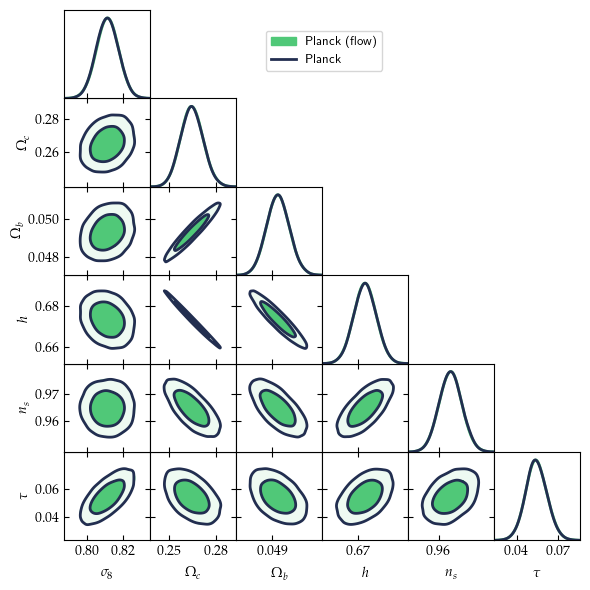

In [83]:
flow_samples = flow.generate_samples(50000)
# triangle_cosmology(training_points.values, flow_samples, 'Planck', 'Planck (flow)', fname = 'triangle_P18_tau_lcdm_nu')

# Sampling 

In [21]:
def load_flow(experiment: str) -> NormFlow:
    """Load a pre-trained normalising flow.

    Args:
        experiment (str): name of the experiment (flow)

    Returns:
        NormFlow: the pre-trained normalising flow
    """
    flow = torch.load(f"flows/{experiment}.pt")
    return flow


def loglike_flows(sample, flows):

    keys = list(flows.keys())
    logl = 0.0
    for key in keys:
        if 'P18' in key:
            logl += flows[key].loglike(sample).item()
        else:
            logl += flows[key].loglike(sample[0:5]).item()
    return logl

def loglike_flow_planck(sample, flow):
    return flow.loglike(sample).item()

This is just a check using the log-density of the flow.

In [22]:
class SampleFlowPlanck:
    """Draw samples from the joint, given a list of experiments.

    Args:
        experiments (list): a list of experiments we want to use.
    """

    def __init__(self, flow):

        self.flow = flow
        self.mean = self.flow.samples.mean(0)
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim

    def sampler(self, nsamples: int, eps: float) -> EnsembleSampler:
        """Sample the joint using emcee.

        Args:
            nsamples (int): the number of samples we want
            eps (float): the step-size to use in emcee.

        Returns:
            EnsembleSampler: the emcee Ensemble sampler
        """
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = EnsembleSampler(
            self.nwalkers, self.ndim, loglike_flow_planck, args=(self.flow,)
        )
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In this case, we are doing a joint with the two flow models.

In [28]:
class SampleFlow:
    """Draw samples from the joint, given a list of experiments.

    Args:
        experiments (list): a list of experiments we want to use.
    """

    def __init__(self, experiments: list):

        self.flows = {e: load_flow(e) for e in experiments}
        self.nexp = len(self.flows)
        self.mean = self.flows[experiments[0]].samples.mean(0)
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim

    def sampler(self, nsamples: int, eps: float) -> EnsembleSampler:
        """Sample the joint using emcee.

        Args:
            nsamples (int): the number of samples we want
            eps (float): the step-size to use in emcee.

        Returns:
            EnsembleSampler: the emcee Ensemble sampler
        """
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = EnsembleSampler(
            self.nwalkers, self.ndim, loglike_flows, args=(self.flows,)
        )
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [29]:
fname_1 = 'P18_lcdm_nu_tau'
fname_2 = 'FD_Garcia-Garcia2021_dzMarg_mMarg_nu'
sampling = SampleFlow([fname_1, fname_2])

In [35]:
# sampler = sampling.sampler(10000, 1E-3)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [17:53<00:00,  9.31it/s]


In [56]:
def dill_save(file: Any, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        fname (str): the name of the file.
    """

    # get the folder where the files are stored
    folder = 'mcmcsamples/'

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)

def dill_load(folder: str, fname: str) -> Any:
    """Reads a file from a folder.
    Args:
        folder(str): the name of the folder.
        file (str): the name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = dill.load(dummy)
    return file

In [57]:
# dill_save(sampler, 'P18_tau_FD')

In [58]:
sampler = dill_load('mcmcsamples', 'P18_tau_FD')

In [60]:
fd_flow_planck_flow = sampler.get_chain(flat=True, discard=500)

These are the samples from the known joint.

In [6]:
def process_samples_FD_P18(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu' 
    columns = [-12, 3, 4, 5, 6, 7]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck is: {df.shape[0]}')
    return df

In [7]:
original_samples = process_samples_FD_P18(burnin=0.25)

Total number of samples for Oxford Full Dataset + Planck is: 34679


# FD and Planck (flow) - From Carlos

In [62]:
def process_samples_FD_P18_flow(burnin=None, thin=None):
    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18flowtauHack_lcdm_nu2' 
    columns = [-6, 3, 4, 5, 6, 7]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        flow_like = samples[:,-2]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
            flow_like = flow_like[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS_tau)
    print(f'Total number of samples for Oxford Full Dataset + Planck (Flow) is: {df.shape[0]}')
    return df

In [64]:
fd_planck_flow = process_samples_FD_P18_flow(burnin=0.25)

Total number of samples for Oxford Full Dataset + Planck (Flow) is: 10088


# Triangle Plots

Removed no burn in
Removed no burn in


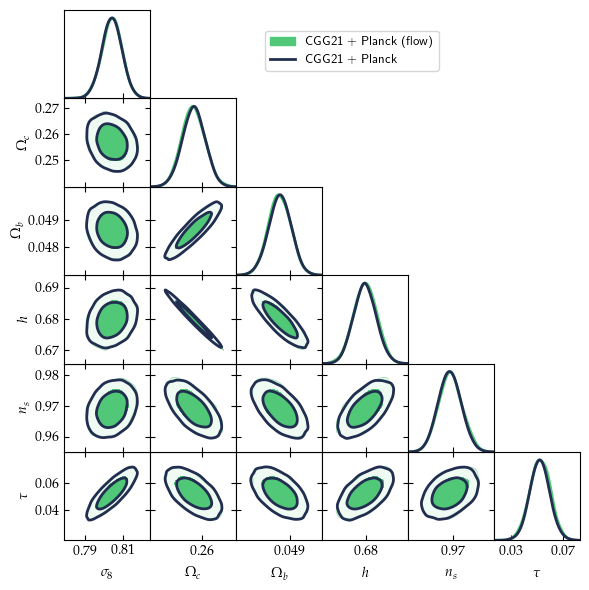

In [85]:
triangle_cosmology(original_samples.values, fd_planck_flow.values, 
                   'CGG21 + Planck', 'CGG21 + Planck (flow)',
                  fname = 'triangle_plot_fd_planck_flow')

Removed no burn in
Removed no burn in


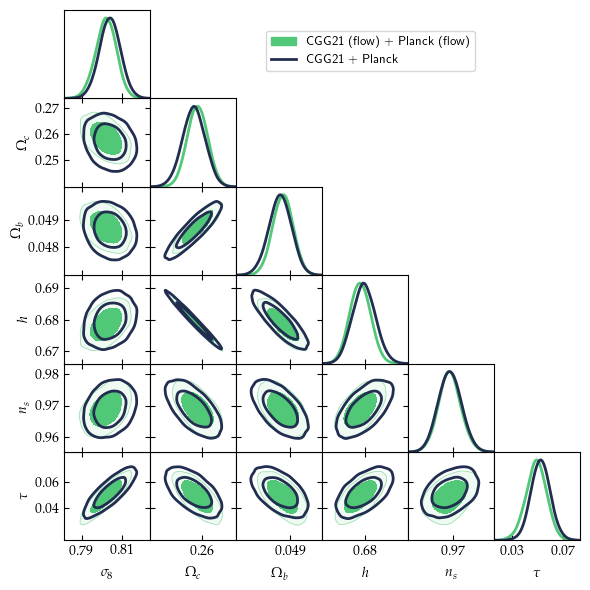

In [87]:
triangle_cosmology(original_samples.values, fd_flow_planck_flow, 
                   'CGG21 + Planck', 'CGG21 (flow) + Planck (flow)',
                  fname = 'triangle_plot_fd_flow_planck_flow')

# Metrics

In [71]:
class TransForm:

    def __init__(self, samples):
        
        self.ndim = samples.shape[1]
        self.samples = samples
        self.cov_train = np.cov(samples.T)
        self.cholesky = np.linalg.cholesky(self.cov_train)
        self.cholesky_inv = np.linalg.inv(self.cholesky)
        self.mean = np.mean(samples, axis = 0).reshape(-1, self.ndim)
        
    def forward(self, testpoint):
        testpoint = testpoint.reshape(-1, self.ndim)
        testtrans = self.cholesky_inv @ (testpoint - self.mean).T
        return testtrans.T

    def inverse(self, prediction):
        prediction = prediction.reshape(-1, self.ndim)
        predtrans = self.cholesky @ prediction.T + self.mean.T
        return predtrans.T

def energy_distance_multivariate(X, Y):
    dist_within_x = cdist(X, X, 'euclidean').mean()
    dist_within_y = cdist(Y, Y, 'euclidean').mean()
    dist_between = cdist(X, Y, 'euclidean').mean()
    return (2 * dist_between - dist_within_x - dist_within_y) / (2.0 * dist_between)

def rbf_kernel_multivariate(X, Y, sigma=1.0):
    return rbf_kernel(X, Y, gamma=1/(2*sigma**2))

def compute_mmd(X, Y, sigma=1.0):
    XX = np.mean(rbf_kernel_multivariate(X, X, sigma))
    YY = np.mean(rbf_kernel_multivariate(Y, Y, sigma))
    XY = np.mean(rbf_kernel_multivariate(X, Y, sigma))
    return XX + YY - 2 * XY

class metric_calculations(TransForm):
    def __init__(self, samples_1, samples_2):
        """
        By default, samples_1 is the "known" distribution.
        """
        self.samples_1 = samples_1
        self.samples_2 = samples_2
        self.mean_1 = np.mean(samples_1, axis = 0)
        self.mean_2 = np.mean(samples_2, axis = 0)
        self.std_1 = np.std(samples_1, axis = 0)
        self.std_2 = np.std(samples_2, axis = 0)
        self.names = ['sigma_8', 'Omega_cdm', 'Omega_b', 'h', 'n_s', 'tau']
        self.ndim = len(self.names)
        TransForm.__init__(self, samples_1)
    
    def delta_mean(self):
        print('-'*50)
        error = (np.abs((self.mean_1 - self.mean_2) / self.mean_1))
        print('delta mean')
        for i in range(self.ndim):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')

    def delta_std(self):
        print('-'*50)
        error = (np.abs(self.std_1 - self.std_2) / self.std_1)
        print('delta standard deviation')
        for i in range(self.ndim):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')  

    def statistics(self):
        
        print('-'*50)
        print('Samples 1 Statistics')
        for i in range(self.ndim):
            print(f'{self.names[i]:<15}: {self.mean_1[i]:.3f} \u00B1 {self.std_1[i]:.3f}')
        print('-'*50)
        print('Samples 2 Statistics')
        for i in range(self.ndim):
            print(f'{self.names[i]:<15}: {self.mean_2[i]:.3f} \u00B1 {self.std_2[i]:.3f}')
    
    def delta_quad(self):
        print('-'*50)
        error = (np.abs(self.mean_1 - self.mean_2) / np.sqrt(self.std_1**2 + self.std_2**2))
        print('Tension in 1D (Difference of Gaussians)')
        for i in range(self.ndim):
            print(f'{self.names[i]:<15}: {error[i]:.3f}')  
    
    def distance_measure(self, nsamples=2000, repeat = 1, sigma = 1.0, method = 'mmd'):
        print('-'*50)
        samples_1 = TransForm.forward(self, self.samples_1)
        samples_2 = TransForm.forward(self, self.samples_2)
        nsamples_1 = samples_1.shape[0]
        nsamples_2 = samples_2.shape[0]
        record = []
        for i in range(repeat):
            randint = idx = random.sample(range(1, min([nsamples_1, nsamples_2])), nsamples)
            samples_P = samples_1[idx]
            samples_Q = samples_2[idx]
            if method == 'mmd':
                distance = compute_mmd(samples_P, samples_Q, sigma=sigma)
            elif method == 'energy':
                distance = energy_distance_multivariate(samples_P, samples_Q)
            record.append(distance)
        mean_mmd = np.mean(record)
        std_mmd = np.std(record)
        formatted_string = f"Distance {method:<10}:"
        print(f'{formatted_string} {mean_mmd:.4f} \u00B1 {std_mmd:.4f}')
        return mean_mmd, std_mmd

def print_stats(samples_1, samples_2, nsamples=2000, nrepeat = 5, sigma = 1.0):
    metrics = metric_calculations(samples_1, samples_2)
    metrics.statistics()
    metrics.delta_mean()
    metrics.delta_std()
    metrics.delta_quad()
    mean_mmd, std_mmd = metrics.distance_measure(nsamples=nsamples, repeat=nrepeat, sigma=sigma, method='mmd')
    mean_energy, std_energy = metrics.distance_measure(nsamples=nsamples, repeat=nrepeat, sigma=sigma, method='energy')

In [74]:
print_stats(original_samples.values, fd_planck_flow.values, nsamples=3000)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.804 ± 0.005
Omega_cdm      : 0.257 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.680 ± 0.004
n_s            : 0.969 ± 0.004
tau            : 0.052 ± 0.008
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.804 ± 0.005
Omega_cdm      : 0.257 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.680 ± 0.004
n_s            : 0.969 ± 0.004
tau            : 0.053 ± 0.008
--------------------------------------------------
delta mean
sigma_8        : 0.000
Omega_cdm      : 0.000
Omega_b        : 0.000
h              : 0.000
n_s            : 0.000
tau            : 0.005
--------------------------------------------------
delta standard deviation
sigma_8        : 0.006
Omega_cdm      : 0.015
Omega_b        : 0.007
h              : 0.027
n_s            : 0.031
tau            : 0.028
--------------------------------------------------
Tension in 1D (Diff

In [72]:
print_stats(original_samples.values, fd_flow_planck_flow, nsamples=3000)

--------------------------------------------------
Samples 1 Statistics
sigma_8        : 0.804 ± 0.005
Omega_cdm      : 0.257 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.680 ± 0.004
n_s            : 0.969 ± 0.004
tau            : 0.052 ± 0.008
--------------------------------------------------
Samples 2 Statistics
sigma_8        : 0.802 ± 0.005
Omega_cdm      : 0.258 ± 0.004
Omega_b        : 0.049 ± 0.000
h              : 0.678 ± 0.003
n_s            : 0.969 ± 0.004
tau            : 0.049 ± 0.008
--------------------------------------------------
delta mean
sigma_8        : 0.002
Omega_cdm      : 0.006
Omega_b        : 0.002
h              : 0.002
n_s            : 0.000
tau            : 0.067
--------------------------------------------------
delta standard deviation
sigma_8        : 0.021
Omega_cdm      : 0.107
Omega_b        : 0.107
h              : 0.096
n_s            : 0.036
tau            : 0.052
--------------------------------------------------
Tension in 1D (Diff